# Análise Básica de Séries Temporais

O estudo de fenômenos que variam no tempo é uma prática bastante utilizada em Astronomia. Este Jupyter Notebook traz alguns exemplos modestos de como utilizar algumas ferramentas baseadas em Python para encontrar o período presente em séries temporais.

[1. O conceito de dobra em fase para busca de períodos](#dobra_fase)

[2. O periodograma de Lomb-Scargle](#lombscargle)

[3. PDM - Phase Dispersion Minimization](#pdm)

[4. Ajustando um modelo utilizando o módulo LMFIT](#lmfit)

[5. Visualizando a Transformada de Fourier](#dft_visualization)


### Bibliotecas utilizadas

In [1]:
# manipulação de arrays
import numpy as np

# biblioteca gráfica
import matplotlib.pyplot as plt

# Astropy
# biblioteca de rotinas astronômicas
from astropy.stats import LombScargle
from astropy.io import fits

# PyAstronomy
# biblioteca com algumas opções para séries temporais
from PyAstronomy.pyTiming import pyPDM

# Scipy
# biblioteca de rotinas matemáticas e estatísticas
from scipy.signal import savgol_filter

# LMFIT
# biblioteca de rotinas de minimização
from lmfit import minimize, Minimizer, Parameters, report_fit

# Bokeh
# biblioteca de visualização interativa
from bokeh.layouts import column
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import figure, output_notebook, show

### Algumas funções utilizadas

In [2]:
# funcao que le arquivo de texto com tres colunas numéricas (float)
# (sugestão: use numpy.genfromtxt se necessitar ler floats e strings)
def read_txt(file):
    time, flux, err = np.loadtxt(file, usecols=(0,1,2), \
                                 unpack=True, comments="#")
    return time, flux, err

# calcula o periodograma de lombscargle
# retorna melhor frequência, melhor potência, 
# probabilidade de falso alarme,
# periodograma e modelo do ajuste
def scargle(x, y, err, frequencia, plot=False):
    from astropy.stats import LombScargle
    # objeto contendo as propriedades do calculo
    ls = LombScargle(x, y, err)

    # calcula o o periodograma
    power = ls.power(frequencia)

    # localiza a o índice do maior pico
    idx = np.argmax(power)

    # melhor frequência e pico correspondente
    best_freq = frequencia[idx]
    best_power = power[idx]
    modelo = ls.model(x,best_freq)

    # calcula a probabilidade de falso alarme
    fap = ls.false_alarm_probability(best_power, method='baluev', \
                                     minimum_frequency=frequencia.min(), \
                                     maximum_frequency=frequencia.max())

    print('Frequência: {0:.8f} (Período: {1:.8f})\nFAP: {2:6.2f}%'.format(best_freq,1/best_freq,fap*100))
    if plot:
        # plota resultados
        phase = (x*best_freq) % 1
        fig, ax = plt.subplots(1,2, figsize=(14,6))
        ax[0].errorbar(phase, y, err, fmt='.', color='blue', label='Medidas')
        srt = np.argsort(phase) # obtem o indice da fase ordenada
        ax[0].plot(phase[srt], modelo[srt], '-', color='red', label='Modelo')
        ax[0].set_xlabel("Fase")
        ax[0].set_ylabel("Fluxo")
        ax[0].legend()

        ax[1].plot(frequencia, power, color='darkgreen')
        ax[1].set_xlabel("Frequência")
        ax[1].set_ylabel(r'$P(\omega)$')
        plt.show()
    return best_freq, best_power, fap, power, modelo


# Ler arquivo CoRoT do campo sismo
def read_an2_corot(file):
    hdul = fits.open(file)
    data = hdul[1].data
    status = data['RAWSTATUS']  # status 0 == valid measurements
    time  = data['DATETT']
    flux  = data['RAWFLUX']
    fluxerror = data['RAWFLUXDEV']
    mask = (status == 0)

    time = np.ascontiguousarray(time[mask], dtype=np.float64)
    flux = np.ascontiguousarray(flux[mask], dtype=np.float64)
    fluxerror = np.ascontiguousarray(fluxerror[mask], dtype=np.float64)
                                
    return time, flux, fluxerror


# Ler arquivo CoRoT do campo exo
def read_en2_corot(file):
    hdul = fits.open(file)
    data = hdul[1].data
    status = data['STATUS']  # status 0 == valid measurements
    time  = data['DATEBARTT']
    flux  = data['WHITEFLUX']
    mask = (status == 0)

    time = np.ascontiguousarray(time[mask], dtype=np.float64)
    flux = np.ascontiguousarray(flux[mask], dtype=np.float64)
    return time, flux


# retorna modelo e residuos (respectivamente)
def box_model(pars, x):
    v = pars.valuesdict()
    yfit = np.zeros(len(x)) + v['baseflux']
    indice = (x > v['t1']) & (x < v['t2'])
    yfit[indice] = v['depth']    
    return yfit

def boxfit(pars, x, y):
    yfit = box_model(pars,x)
    return (y - yfit)

## 1. O conceito de dobra em fase para busca de períodos
<a id="dobra_fase"></a>
Quando buscamos períodos em séries temporais não sabemos de antemão, exceto quando temos informações a priori do sistema estudado, em qual região ou intervalo de períodos ele será mais provável de ser encontrado. Dessa forma, todo o espaço de parâmetros precisa ser buscado. Uma maneira conveniente de se fazer isso é dobrar a série temporal em uma fase de período teste e utlizando ajuste de funções (por exemplo, Lomb-Scargle, BLS...) ou estudo de de dispersão (por exemplo, PDM) pode-se estimar a qualidade do ajuste com respeito a algum tipo de referência.

Neste bloco é mostrado visualmente o conceito. A seguir iremos utiliza estas técnicas para detectar o período nesta série de exemplo, uma curva de luz obtida com medidas do satélite CoRoT.

In [3]:
# gera saída do bokeh no notebook
output_notebook()

arquivo = 'CoRoT_id_0102609164.txt'
x, y, err = read_txt(arquivo)

c = int(len(x)/3)
x, y, err = x[0:c], y[0:c], err[0:c]

ph = np.zeros(len(x))
ph_dummy = np.zeros(len(x))

# gera objeto que contém a interatividade
source = ColumnDataSource(data=dict(x=x, y=y, ph=ph))

# gera os gráficos
p0 = figure(plot_width=900, plot_height=300, x_range=(x.min(),x.max()))
p0.circle('x', 'y', source=source, size=2, alpha=0.5, color='red')
p0.xaxis.axis_label = "Data Juliana (dias)"
p0.yaxis.axis_label = "Fluxo Arbitrário"

p1 = figure(plot_width=900, plot_height=300, x_range=(0,1))
p1.circle('ph', 'y', source=source, size=8, alpha=0.3)
p1.xaxis.axis_label = "Fase"
p1.yaxis.axis_label = "Fluxo Arbitrário"


# função que dá origem à interação (em javascript para funcionar em JupNtbk)
callback = CustomJS(args=dict(source=source), code="""
        var data = source.data;
        var f = cb_obj.value
        var x = data['x']
        var y = data['y']
        var ph = data['ph']
        for (var i = 0; i < x.length; i++){
            ph[i] = (x[i]/f) % 1
        }
        source.change.emit();
    """)
# cria botão de interação e respectivos limites, valor inicial e passo
slider = Slider(start=0.5, end=1.5, value=0, step=0.0001, title="Período teste")
slider.js_on_change('value', callback)

# mostra os resultados
layout = column(slider, p0, p1)
show(layout)

Loading BokehJS ...

## 2. O periodograma de Lomb-Scargle
<a id="lombscargle"></a>

O periodograma de Lomb-Scargle é uma técnica que testa frequências (ou períodos) a partir de ajustes de mínimos quadrados. A "potência" do espectro é calculada a partir da relação:
$$
P_{x}(\omega)=\frac{1}{2}\left(\frac{\left[\sum_{j} X_{j} \cos \omega\left(t_{j}-\tau\right)\right]^{2}}{\sum_{j} \cos ^{2} \omega\left(t_{j}-\tau\right)}+\frac{\left[\sum_{j} X_{j} \sin \omega\left(t_{j}-\tau\right)\right]^{2}}{\sum_{j} \sin ^{2} \omega\left(t_{j}-\tau\right)}\right)
$$
onde, $\tau$ é dado por $\tan 2 \omega \tau=\frac{\sum_{j} \sin 2 \omega t_{j}}{\sum_{j} \cos 2 \omega t_{j}}$.

Frequência: 0.01640000 (Período: 60.97560976)
FAP:   0.00%


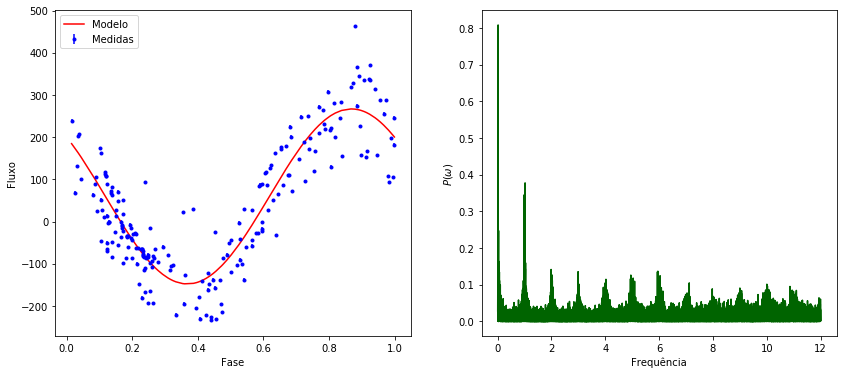

In [4]:
arquivo = 'GJ876_rv.txt'

x, y, err = read_txt(arquivo)
# remove o valor médio
# y -= np.mean(y)

# cria array de frequencias a ser estudadas
frequencia = np.arange(0.001,12,0.0001)

# objeto contendo as propriedades do calculo
ls = LombScargle(x, y, err)

# calcula o o periodograma
power = ls.power(frequencia)

# localiza a o índice do maior pico
idx = np.argmax(power)

# melhor frequência e pico correspondente
best_freq = frequencia[idx]
best_power = power[idx]
modelo = ls.model(x,best_freq)

# calcula a probabilidade de falso alarme
fap = ls.false_alarm_probability(best_power, method='baluev', \
                                 minimum_frequency=frequencia.min(), \
                                 maximum_frequency=frequencia.max())

print('Frequência: {0:.8f} (Período: {1:.8f})\nFAP: {2:6.2f}%'.format(best_freq,1/best_freq,fap*100))

# plota resultados
phase = (x*best_freq) % 1
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].errorbar(phase, y, err, fmt='.', color='blue', label='Medidas')
srt = np.argsort(phase) # obtem o indice da fase ordenada
ax[0].plot(phase[srt], modelo[srt], '-', color='red', label='Modelo')
ax[0].set_xlabel("Fase")
ax[0].set_ylabel("Fluxo")
ax[0].legend()

ax[1].plot(frequencia, power, color='darkgreen')
ax[1].set_xlabel("Frequência")
ax[1].set_ylabel(r'$P(\omega)$')
plt.show()

### Refinando frequências e analisando resíduos

Frequência: 0.01639600 (Período: 60.99048548)
FAP:   0.00%


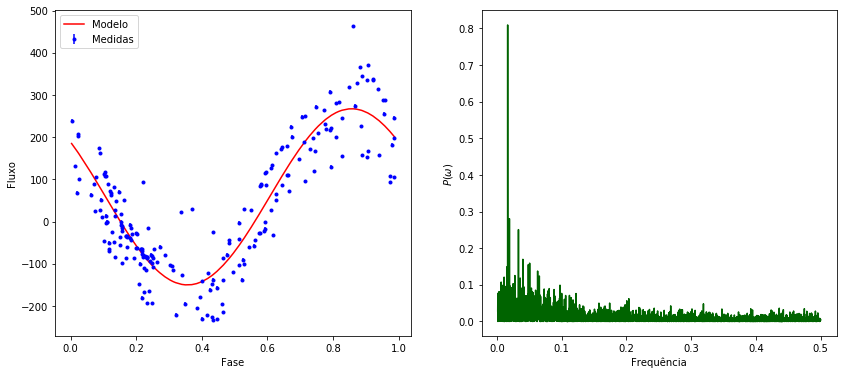

In [5]:
### Z
frequencia = np.arange(0.001,0.5,0.000001)
best_freq, best_power, fap, power, modelo = scargle(x, y, err, frequencia, plot=True)

Frequência: 0.03309200 (Período: 30.21878400)
FAP:   0.00%


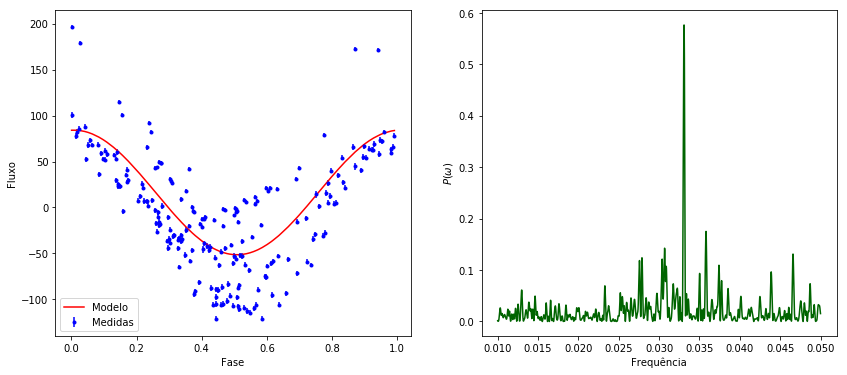

In [6]:
### Removendo o pico principal
frequencia = np.arange(0.01,0.05,0.000001)
y2 = y - modelo
best_freq2, best_power2, fap2, power2, modelo2 = scargle(x, y2, err, frequencia, plot=True)

In [7]:
### fazendo um laço
### para remover frequências iterativamente
nf = 5   # número de frequências
frequencias = np.arange(0.001,12,0.0001)
residuos = np.zeros(len(x))
yfit = np.zeros(len(x))
y2 = y
best_freq, best_power, fap = np.zeros(int(nf)), np.zeros(int(nf)), np.zeros(int(nf))

for i in range(nf):
    print('=== Análise da {0}ª frequência ==='.format(i+1))
    best_freq[i], best_power[i], fap[i], power, modelo = scargle(x, y2, err, frequencia, plot=False)
    yfit += modelo
    residuos = y2-modelo
    wrms = np.sqrt(np.sum(err*(y2 - modelo)**2))
    print('WRMS: {0:.4f}\n\n\n'.format(wrms))
    y2 = residuos


=== Análise da 1ª frequência ===
Frequência: 0.01639600 (Período: 60.99048548)
FAP:   0.00%
WRMS: 1489.4865



=== Análise da 2ª frequência ===
Frequência: 0.03309200 (Período: 30.21878400)
FAP:   0.00%
WRMS: 888.7517



=== Análise da 3ª frequência ===
Frequência: 0.03220200 (Período: 31.05397180)
FAP:   0.00%
WRMS: 795.3916



=== Análise da 4ª frequência ===
Frequência: 0.04659800 (Período: 21.46014850)
FAP:   0.00%
WRMS: 749.0248



=== Análise da 5ª frequência ===
Frequência: 0.02105600 (Período: 47.49240122)
FAP:   0.31%
WRMS: 702.8100





## 3. PDM - Phase Dispersion Minimization
<a id="#pdm"></a>

O PDM é uma técnica que testa qual a dispersão total que uma determinada curva de fase possui quando é dobrada em um determinado período teste. 

É relativamente simples verificar que quando encontramos o período correto de uma determinada variabilidade periódica haverá o ‘encaixe’ adequado ao longo da fase do período. Isso significa que se dividirmos este espaço de fase em pequenas partes, que normalmente chamamos de **bins**, e na ausência de fatores sistemáticos, se medirmos o desvio padrão dentro de cada bin, ele será o menor possível quando o período testado for o período correto da variabilidade. Podemos então produzir um diagrama da soma dos resíduos de todos os bins como uma função do período testado e então verificar qual o período teste que possui a menor dispersão.


Frequência: 1.10200000 (Período: 0.90744102)
WRMS: 0.3957


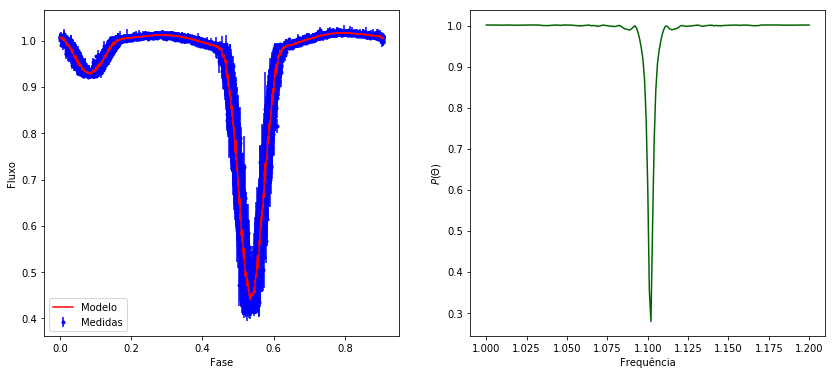

In [8]:
arquivo = 'CoRoT_id_0102609164.txt'
x, y, err = read_txt(arquivo)
n_bins = 10

P = pyPDM.PyPDM(x, y)
scan = pyPDM.Scanner(minVal=1.0, maxVal=1.2, dVal=0.001, mode="frequency")

# calcula o pdm
frequencia, theta = P.pdmEquiBinCover(n_bins, 5, scan)

# localiza a o índice do maior pico
idx = np.argmin(theta)

# melhor frequência e pico correspondente
best_freq = frequencia[idx]
best_power = power[idx]

# calcular modelo utilizando o filtro de Savitzky-Golay
phase = x % (1/best_freq)
idx_tmp = np.argsort(phase) # ordena em fase
# Modelo baseado no filtro de Savitzky-Golay
result = savgol_filter(y[idx_tmp], 35, 4, mode='nearest')
modelo = result[np.argsort(idx_tmp)]
wrms = np.sqrt(np.sum(err*(y - modelo)**2))    
print('Frequência: {0:.8f} (Período: {1:.8f})'.format(best_freq,1/best_freq))
print('WRMS: {0:.4f}'.format(wrms))

# plota resultados
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].errorbar(phase, y, err, fmt='.', color='blue', label='Medidas')
srt = np.argsort(phase) # obtem o indice da fase ordenada
ax[0].plot(phase[srt], modelo[srt], '-', color='red', label='Modelo', zorder=20)
ax[0].set_xlabel("Fase")
ax[0].set_ylabel("Fluxo")
ax[0].legend()

ax[1].plot(frequencia, theta, color='darkgreen')
ax[1].set_xlabel("Frequência")
ax[1].set_ylabel(r'$P(\Theta)$')
plt.show()

## 4. Ajustando um modelo utilizando a biblioteca LMFIT
<a id="lmfit"></a>

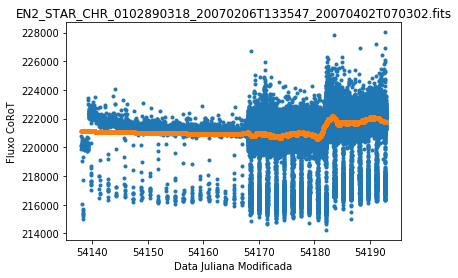

In [9]:
arquivo = 'EN2_STAR_CHR_0102890318_20070206T133547_20070402T070302.fits'
time, flux = read_en2_corot(arquivo)

periodo = 1.5089682
# Remover trends com um filtro Savitzky-Golay
modelo = savgol_filter(flux, 9501, 2, mode='nearest')

# Plota dados
plt.title(arquivo)
plt.plot(time, flux, '.')
plt.plot(time, modelo, '.')
plt.xlabel('Data Juliana Modificada')
plt.ylabel('Fluxo CoRoT')
plt.show()

Relatório do ajuste:
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 2850
    # data points      = 61795
    # variables        = 4
    chi-square         = 0.56469145
    reduced chi-square = 9.1387e-06
    Akaike info crit   = -717002.694
    Bayesian info crit = -716966.567
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this.  Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    baseflux:  1.00118668 (init = 1)
    t1:        1.03255729 (init = 1)
    t2:        1.11752500 (init = 1.2)
    depth:     0.98074675 (init = 0.9)
None


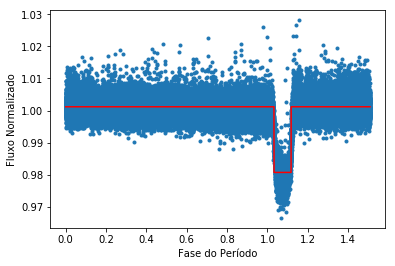

In [10]:
# Normaliza medidas
flux_norm = flux/modelo

phase = time % periodo
idx = np.argsort(phase)
x2 = phase[idx]
y2 = flux_norm[idx]


# cria dicionário de parâmetros a ser ajustados
p = Parameters()
p.add_many(('baseflux', 1, True, 0.9, 1.1), \
           ('t1', 1, True, 0, periodo), \
           ('t2', 1.2, True, 0, periodo), \
           ('depth', 0.9, True, 0.8, 1.0))

init =  Minimizer(boxfit, p, nan_policy='omit', fcn_args=(x2,y2))
result = init.minimize(method='differential_evolution')
print('Relatório do ajuste:')
print(report_fit(result))

yfit = box_model(result.params,x2)
plt.plot( x2, y2, '.')
plt.plot( x2, yfit, 'r-')
plt.xlabel('Fase do Período')
plt.ylabel('Fluxo Normalizado')
plt.show()

## 5. Visualizando a Transformada de Fourier (EPO application)
<a id="dft_visualization"></a>
(Baseado em: [But what is the Fourier Transform? A visual introduction.](https://youtu.be/spUNpyF58BY))

**Transformada de Fourier** (equação de análise):

$$ X(\omega)=\int_{-\infty}^{+\infty} x(t) e^{-j \omega t} d t $$

onde, a partir da identidade de Euler, $e^{-j \omega t} = \cos{\omega t} -j\sin{\omega t}$.

In [11]:
import numpy as np
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import figure, output_notebook, show

output_notebook()

# definir parametros do sinal
ruido = False
subtrair_media = True

amp = [1.0, 2.0, 3.6]
f = [2.0, 5.0, 3.5]
phase = [0.1, 0.27, 0.7]
h = 10.0    # valor médio adicionado ao sinal

sampling = 0.01    # amostragem do sinal em seg/ciclo

fini = 0.0   # frequência inicial a ser buscada
fend = 30    # frequência final a ser buscada
fstep = 0.01 # passo em frequência

nyqst = 1/(2*sampling)
print('Limite de Nyqst: {0:5.1f} ciclos/segundo'.format(nyqst))
# construir variáveis
nf = len(f)
x = np.arange(0,5,sampling)  # variavel independente x
ys = np.zeros((nf,len(x)))   # array para conter sinais individuais
y = np.zeros(len(x))         # array contendo sinais somados
for i in range(nf):
    ys[i,:] = amp[i]*np.sin(2*np.pi*(f[i]*x + phase[i]))
    y += ys[i,:]
y += h                       # adiciona valor médio do sinal


# definir funcoes usadas dentro do js (devem ser declaradas antes do callback)
im, re = np.zeros(len(x)),np.zeros(len(x))
mgi =  np.linspace(0,1,len(x))
mgr =  np.linspace(0,1,len(x))
magf = np.linspace(0,1,len(x))
fmag = np.zeros(len(x))
yfit = np.zeros(len(x))

freq = np.arange(fini,fend,fstep)
mag = np.zeros(len(freq))
theta = np.zeros(len(freq))

noise = np.random.normal(0,2,len(x))  # ruido gaussiano com média 0 e desvio padrao 2
if ruido:
    y += noise

if subtrair_media:
    y -= np.mean(y)

    

    
# calculo do objeto interativo
source = ColumnDataSource(data=dict(x=x, y=y, im=im, re=re, mgi=mgi, \
                                    mgr=mgr, magf=magf, fmag=fmag, yfit=yfit))
# plota sinais separados
s0 = figure(plot_width=600, plot_height=165, x_range=(x.min(),x.max()), title='Sinal Arbitrário')

ran = np.zeros(len(x))
for i in range(nf):
    ran += ys[i,:].max()-ys[i,:].min()
    s0.line(x, ys[i,:]+ran+3)
s0.axis.visible=False
# plota sinais somados
s3 = figure(plot_width=600, plot_height=165, x_range=(x.min(),x.max()))
s3.line(x, y)
s3.line('x', 'yfit', source=source, line_alpha=0.8, color='red')
s3.yaxis.axis_label = "Intensidade"
s3.xaxis.axis_label = "Tempo (segundos)"


rg = 1.25*y.max()

# calcula dft
for j,i in enumerate(freq):
    r1 = y*np.cos(-2*np.pi*x*i)/len(x)
    im1 = y*np.sin(-2*np.pi*x*i)/len(x)  
    r1 = np.sum(r1)
    im1 = np.sum(im1)
    mag[j] = 2*np.sqrt(r1**2 + im1**2)

# plota plano
s1 = figure(plot_width=300, plot_height=270,x_range=(-rg,rg), y_range=(-rg,rg))
s1.line(x=[0,0], y=[-rg,rg], color='black')
s1.line(x=[-rg,rg], y=[0,0], color='black')
s1.line('re', 'im', source=source, color='blue', line_alpha=0.2)
s1.circle('re', 'im', source=source, color='blue', alpha=0.2)
s1.circle('mgr','mgi', source=source, color='red', size=5)
s1.xaxis.axis_label = "Real"
s1.yaxis.axis_label = "Imaginário"


nf = np.array([nyqst,nyqst])
np = np.array([0,1.2*mag.max()])
s2 = figure(plot_width=900, plot_height=250,x_range=(fini,fend), y_range=(0,1.05*mag.max()))
s2.line(freq, mag, color='green', line_width=1.5)
s2.circle('fmag','magf', source=source, color='red', size=5)
s2.line(x=nf, y=np, color='blue', legend='Limite de Nyqst')
s2.legend.location = "top_right"
s2.yaxis.axis_label = "Amplitude"
s2.xaxis.axis_label = "Frequência (ciclos/segundo)"


callback = CustomJS(args=dict(source=source), code="""
        const arrSum = arr => arr.reduce((a,b) => a + b, 0);
        var data = source.data;
        var f = cb_obj.value;
        var x = data['x'];
        var y = data['y'];
        var im = data['im'];
        var re = data['re'];
        var mgi = data['mgi'];
        var mgr = data['mgr'];
        var magf = data['magf']
        var fmag = data['fmag']
        var yfit = data['yfit']
        for (var i = 0; i < x.length; i++){
            re[i] = y[i]*Math.cos(-2*Math.PI*x[i]*f)
            im[i] = y[i]*Math.sin(-2*Math.PI*x[i]*f)
        }
        let ret = arrSum(re)/x.length;
        let imt = arrSum(im)/x.length;
        let mg = Math.sqrt(ret*ret + imt*imt);

        var tfix = 0;
        if(imt>0 && ret<0){
            tfix = Math.PI;
        } else if(imt<0 && ret<0){
            tfix = 3*Math.PI/2;
        } else if(imt<0 && ret>0){
            tfix = 2*Math.PI;
        }
        let theta = Math.atan(imt/ret) + tfix


        for (var i = 0; i < x.length; i++){
            mgi[i] = imt;
            mgr[i] = ret;
        //    magf[i] = mg*2*(i/x.length)
            magf[i] = mg*2
            fmag[i] = f;
        }

        for (var i = 0; i < x.length; i++){
            yfit[i] = 2*mg*Math.cos(-2*Math.PI*((f*x[i]) + theta/(2*Math.PI)))
        }
        source.change.emit();
    """)

slider = Slider(start=fini, end=fend, value=0, step=fstep, title="Ciclos por segundo")
slider.js_on_change('value', callback)

layout = column(row(column(s0,s3), column(slider, s1)), s2, width=900)
show(layout)

Loading BokehJS ...

Limite de Nyqst:  50.0 ciclos/segundo
